In [1]:
!pip install pytesseract opencv-python pillow

In [2]:
!sudo apt install tesseract-ocr -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Please upload your cropped view images (top, front, side)...


Saving Screenshot 2025-04-20 123338.png to Screenshot 2025-04-20 123338.png
Saving Screenshot 2025-04-20 123342.png to Screenshot 2025-04-20 123342.png
Saving Screenshot 2025-04-20 123346.png to Screenshot 2025-04-20 123346.png
Could not determine view type for screenshot 2025-04-20 123338.png. Please specify:
1: Top view
2: Front view
3: Side view
Enter choice (1-3): 1
Uploaded Screenshot 2025-04-20 123338.png as TOP_VIEW
Could not determine view type for screenshot 2025-04-20 123342.png. Please specify:
1: Top view
2: Front view
3: Side view
Enter choice (1-3): 2
Uploaded Screenshot 2025-04-20 123342.png as FRONT_VIEW
Could not determine view type for screenshot 2025-04-20 123346.png. Please specify:
1: Top view
2: Front view
3: Side view
Enter choice (1-3): 3
Uploaded Screenshot 2025-04-20 123346.png as SIDE_VIEW
Extracted dimensions from TOP_VIEW: {'width': 100.0, 'depth': 100.0}


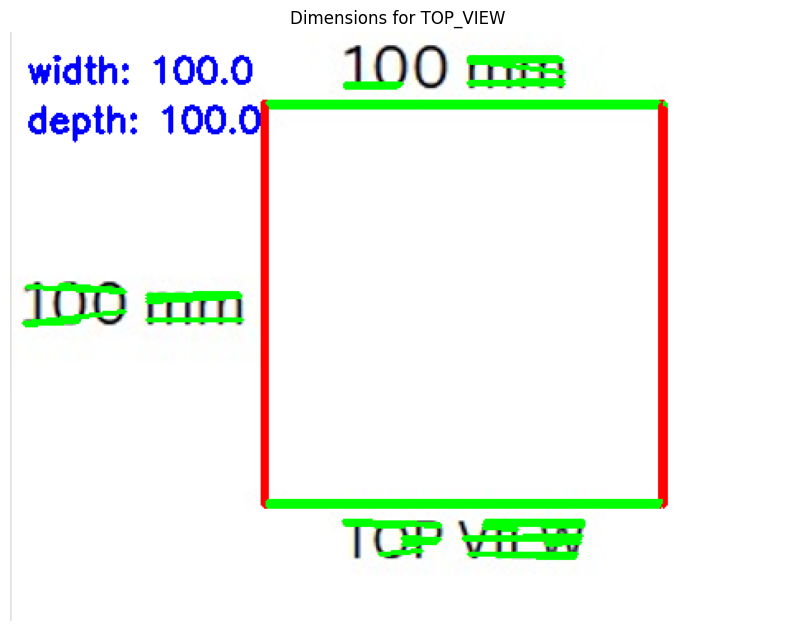

Extracted dimensions from FRONT_VIEW: {'dim_1': 100.0}


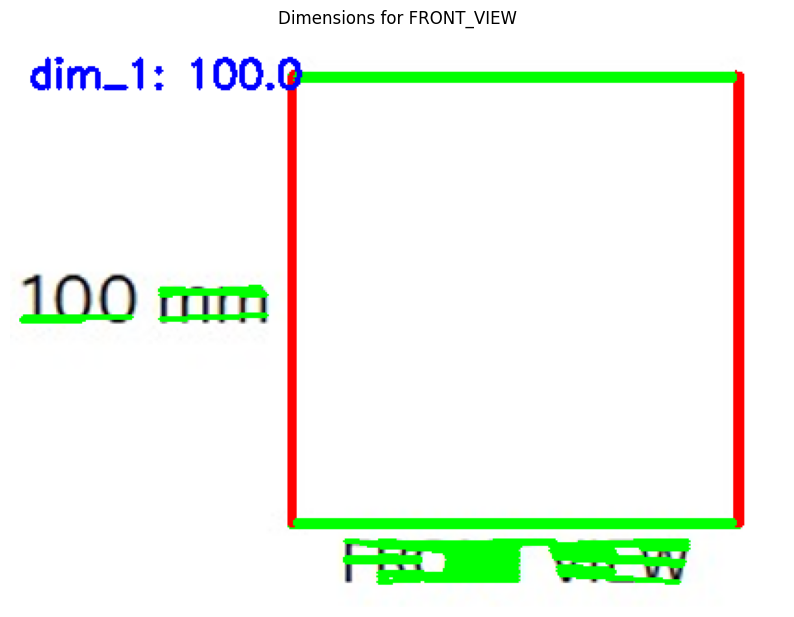

Extracted dimensions from SIDE_VIEW: {'depth': 100.0, 'height': 100.0}


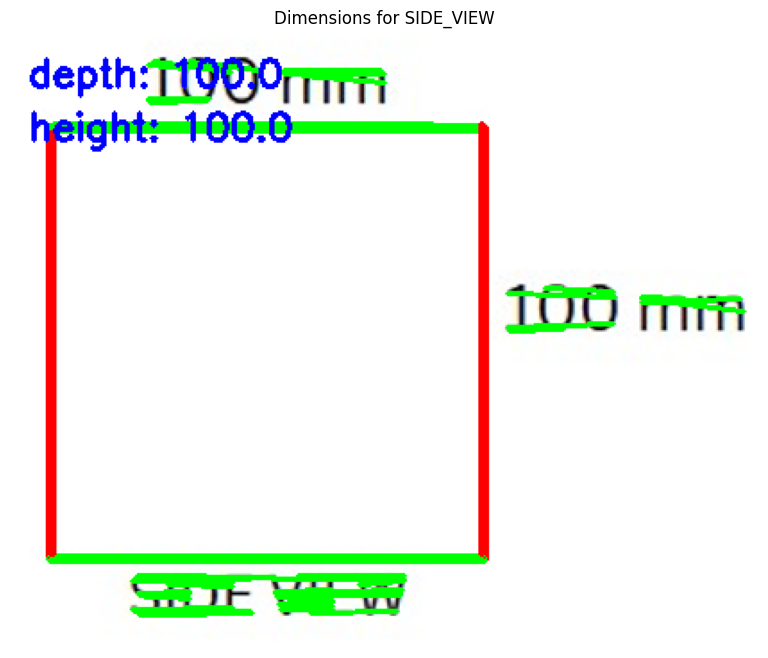


Matched dimensions across views:
  width: 100.0
  height: 100.0
  depth: 100.0
Data exported to extracted_dimensions.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from google.colab import files
import re
import json
import os
from typing import Dict, List, Tuple, Any, Optional

class DimensionExtractor:
    """
    Extract dimensions from cropped engineering drawing views and
    establish relationships between dimensions across views.
    """

    def __init__(self):
        """Initialize the extractor."""
        self.views = {}
        self.dimensions = {}
        self.matched_dimensions = {}

    def upload_views(self):
        """Upload cropped view images in Google Colab."""
        print("Please upload your cropped view images (top, front, side)...")
        view_files = files.upload()

        if not view_files:
            raise ValueError("No files were uploaded")

        for filename, content in view_files.items():
            # Determine view type from filename
            view_type = self._determine_view_type(filename)

            # Decode image
            image = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)

            # Store view
            self.views[view_type] = {
                'image': image,
                'filename': filename
            }

            print(f"Uploaded {filename} as {view_type}")

        return self.views

    def _determine_view_type(self, filename: str) -> str:
        """Determine view type from filename."""
        filename = filename.lower()
        if 'top' in filename:
            return 'TOP_VIEW'
        elif 'front' in filename:
            return 'FRONT_VIEW'
        elif 'side' in filename:
            return 'SIDE_VIEW'
        else:
            # Ask user to specify
            print(f"Could not determine view type for {filename}. Please specify:")
            print("1: Top view")
            print("2: Front view")
            print("3: Side view")
            choice = input("Enter choice (1-3): ")

            if choice == '1':
                return 'TOP_VIEW'
            elif choice == '2':
                return 'FRONT_VIEW'
            elif choice == '3':
                return 'SIDE_VIEW'
            else:
                return f'UNKNOWN_VIEW_{filename}'

    def preprocess_image(self, image):
        """Preprocess image for better text detection."""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Increase contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

        return gray, binary

    def extract_dimensions_from_view(self, view_type: str) -> Dict[str, float]:
        """
        Extract dimensions from a single view using OCR and dimension line detection.

        Args:
            view_type: The type of view (TOP_VIEW, FRONT_VIEW, SIDE_VIEW)

        Returns:
            Dictionary of dimension names and values
        """
        if view_type not in self.views:
            print(f"View {view_type} not found")
            return {}

        view_image = self.views[view_type]['image']
        gray, binary = self.preprocess_image(view_image)

        # Extract text using OCR
        extracted_dimensions = {}

        # First try on the normal image with low threshold
        text_normal = pytesseract.image_to_string(gray)
        dimensions_normal = self._parse_dimensions_from_text(text_normal)

        # Try also on the binary image
        text_binary = pytesseract.image_to_string(binary)
        dimensions_binary = self._parse_dimensions_from_text(text_binary)

        # Try with different preprocessing
        # Resize for better OCR
        resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        text_resized = pytesseract.image_to_string(resized)
        dimensions_resized = self._parse_dimensions_from_text(text_resized)

        # Combine results from different methods
        all_dimensions = {**dimensions_normal, **dimensions_binary, **dimensions_resized}

        # If dimensions were found through OCR
        if all_dimensions:
            # Map dimensions to appropriate names based on view type
            if view_type == 'TOP_VIEW':
                if len(all_dimensions) >= 2:
                    # Try to determine which is width and which is depth
                    dim_keys = list(all_dimensions.keys())
                    extracted_dimensions['width'] = all_dimensions[dim_keys[0]]
                    extracted_dimensions['depth'] = all_dimensions[dim_keys[1]]

                    # If there are more dimensions, add them as extras
                    for i, key in enumerate(dim_keys[2:], start=1):
                        extracted_dimensions[f'extra_{i}'] = all_dimensions[key]
                else:
                    # Just copy over whatever was found
                    extracted_dimensions = all_dimensions

            elif view_type == 'FRONT_VIEW':
                if len(all_dimensions) >= 2:
                    dim_keys = list(all_dimensions.keys())
                    extracted_dimensions['width'] = all_dimensions[dim_keys[0]]
                    extracted_dimensions['height'] = all_dimensions[dim_keys[1]]

                    for i, key in enumerate(dim_keys[2:], start=1):
                        extracted_dimensions[f'extra_{i}'] = all_dimensions[key]
                else:
                    extracted_dimensions = all_dimensions

            elif view_type == 'SIDE_VIEW':
                if len(all_dimensions) >= 2:
                    dim_keys = list(all_dimensions.keys())
                    extracted_dimensions['depth'] = all_dimensions[dim_keys[0]]
                    extracted_dimensions['height'] = all_dimensions[dim_keys[1]]

                    for i, key in enumerate(dim_keys[2:], start=1):
                        extracted_dimensions[f'extra_{i}'] = all_dimensions[key]
                else:
                    extracted_dimensions = all_dimensions

        # Find dimension lines to associate with values
        dimension_lines = self._detect_dimension_lines(binary)

        # Store the results
        self.dimensions[view_type] = {
            'extracted': extracted_dimensions,
            'dimension_lines': dimension_lines
        }

        print(f"Extracted dimensions from {view_type}: {extracted_dimensions}")

        # Display image with highlighted dimension lines
        self._display_view_with_dimensions(view_type, extracted_dimensions, dimension_lines)

        return extracted_dimensions

    def _parse_dimensions_from_text(self, text: str) -> Dict[str, float]:
        """
        Parse dimension values from OCR text.

        Args:
            text: Text extracted from image

        Returns:
            Dictionary of dimension positions and values
        """
        # Pattern to match common dimension formats (e.g., "100 mm", "100mm", "100")
        dimension_pattern = re.compile(r'(\d+(?:\.\d+)?)\s*(?:mm|cm|m)?', re.IGNORECASE)
        matches = dimension_pattern.findall(text)

        # Convert to float and map to positions
        dimensions = {}
        for i, match in enumerate(matches):
            if match:
                try:
                    value = float(match)
                    # Use dimension index as key initially
                    dimensions[f'dim_{i+1}'] = value
                except ValueError:
                    pass

        return dimensions

    def _detect_dimension_lines(self, binary_image):
        """
        Detect dimension lines in the binary image.

        Args:
            binary_image: Preprocessed binary image

        Returns:
            List of detected dimension lines
        """
        # Find lines using Hough transform
        lines = cv2.HoughLinesP(
            binary_image,
            rho=1,
            theta=np.pi/180,
            threshold=50,
            minLineLength=20,
            maxLineGap=10
        )

        dimension_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line angle to separate horizontal and vertical lines
                angle = np.abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))

                # Classify as horizontal, vertical, or diagonal
                if angle < 10 or angle > 170:  # Horizontal lines
                    line_type = 'horizontal'
                elif 80 < angle < 100:  # Vertical lines
                    line_type = 'vertical'
                else:
                    line_type = 'diagonal'

                dimension_lines.append({
                    'coords': (x1, y1, x2, y2),
                    'type': line_type,
                    'length': np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                })

        return dimension_lines

    def _display_view_with_dimensions(self, view_type, dimensions, dimension_lines):
        """Display view with highlighted dimensions."""
        view_image = self.views[view_type]['image'].copy()

        # Draw dimension lines
        for line in dimension_lines:
            x1, y1, x2, y2 = line['coords']
            if line['type'] == 'horizontal':
                color = (0, 255, 0)  # Green for horizontal
            elif line['type'] == 'vertical':
                color = (0, 0, 255)  # Red for vertical
            else:
                color = (255, 0, 0)  # Blue for diagonal

            cv2.line(view_image, (x1, y1), (x2, y2), color, 2)

        # Add dimension values as text
        for i, (dim_name, value) in enumerate(dimensions.items()):
            y_pos = 30 + i * 30
            cv2.putText(
                view_image,
                f"{dim_name}: {value}",
                (10, y_pos),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 0, 0),
                2
            )

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(view_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Dimensions for {view_type}")
        plt.axis('off')
        plt.show()

    def extract_all_dimensions(self):
        """Extract dimensions from all views."""
        for view_type in self.views:
            self.extract_dimensions_from_view(view_type)

        return self.dimensions

    def match_dimensions_across_views(self):
        """
        Match dimensions across different views based on standard engineering drawing
        relationships (similar to the Photo2CAD approach).
        """
        if not self.dimensions:
            print("No dimensions extracted yet")
            return {}

        matched = {
            'width': None,
            'height': None,
            'depth': None
        }

        # Extract standard dimensions from each view if available
        top_dims = self.dimensions.get('TOP_VIEW', {}).get('extracted', {})
        front_dims = self.dimensions.get('FRONT_VIEW', {}).get('extracted', {})
        side_dims = self.dimensions.get('SIDE_VIEW', {}).get('extracted', {})

        # Match width (should be consistent in TOP and FRONT views)
        if 'width' in top_dims and 'width' in front_dims:
            # Check if they're close (within 5%)
            top_width = top_dims['width']
            front_width = front_dims['width']

            if self._are_values_close(top_width, front_width):
                matched['width'] = (top_width + front_width) / 2  # Average them
            else:
                # If they differ significantly, prioritize one (e.g., top view)
                matched['width'] = top_width
                print(f"Warning: Width mismatch between TOP ({top_width}) and FRONT ({front_width}) views")
        elif 'width' in top_dims:
            matched['width'] = top_dims['width']
        elif 'width' in front_dims:
            matched['width'] = front_dims['width']

        # Match height (should be consistent in FRONT and SIDE views)
        if 'height' in front_dims and 'height' in side_dims:
            front_height = front_dims['height']
            side_height = side_dims['height']

            if self._are_values_close(front_height, side_height):
                matched['height'] = (front_height + side_height) / 2
            else:
                matched['height'] = front_height
                print(f"Warning: Height mismatch between FRONT ({front_height}) and SIDE ({side_height}) views")
        elif 'height' in front_dims:
            matched['height'] = front_dims['height']
        elif 'height' in side_dims:
            matched['height'] = side_dims['height']

        # Match depth (should be consistent in TOP and SIDE views)
        if 'depth' in top_dims and 'depth' in side_dims:
            top_depth = top_dims['depth']
            side_depth = side_dims['depth']

            if self._are_values_close(top_depth, side_depth):
                matched['depth'] = (top_depth + side_depth) / 2
            else:
                matched['depth'] = top_depth
                print(f"Warning: Depth mismatch between TOP ({top_depth}) and SIDE ({side_depth}) views")
        elif 'depth' in top_dims:
            matched['depth'] = top_dims['depth']
        elif 'depth' in side_dims:
            matched['depth'] = side_dims['depth']

        # Add any additional dimensions that might be important
        additional_dims = {}

        for view_type, view_dims in self.dimensions.items():
            for dim_name, value in view_dims.get('extracted', {}).items():
                if dim_name.startswith('extra_'):
                    additional_dims[f"{view_type}_{dim_name}"] = value

        matched['additional'] = additional_dims

        # Store the results
        self.matched_dimensions = matched

        return matched

    def _are_values_close(self, val1, val2, tolerance=0.05):
        """Check if two values are close within a tolerance."""
        if val1 == 0 or val2 == 0:
            return val1 == val2

        return abs(val1 - val2) / max(abs(val1), abs(val2)) <= tolerance

    def create_photo2cad_structure(self):
        """
        Create a parent-child structure similar to Photo2CAD.

        Returns:
            Dictionary with the hierarchical structure
        """
        if not self.matched_dimensions:
            self.match_dimensions_across_views()

        # Create the structure
        structure = {
            "root": {
                "type": "object3D",
                "dimensions": {
                    k: v for k, v in self.matched_dimensions.items()
                    if k != 'additional' and v is not None
                },
                "children": []
            }
        }

        # Add views as children
        for view_type, view_data in self.views.items():
            view_node = {
                "id": view_type,
                "type": "view",
                "dimensions": self.dimensions.get(view_type, {}).get('extracted', {})
            }
            structure["root"]["children"].append(view_node)

        # Add relationships between views
        if 'TOP_VIEW' in self.views and 'FRONT_VIEW' in self.views:
            structure["relationships"] = []
            structure["relationships"].append({
                "type": "shares_dimension",
                "dimension": "width",
                "views": ["TOP_VIEW", "FRONT_VIEW"]
            })

        if 'FRONT_VIEW' in self.views and 'SIDE_VIEW' in self.views:
            if not "relationships" in structure:
                structure["relationships"] = []
            structure["relationships"].append({
                "type": "shares_dimension",
                "dimension": "height",
                "views": ["FRONT_VIEW", "SIDE_VIEW"]
            })

        if 'TOP_VIEW' in self.views and 'SIDE_VIEW' in self.views:
            if not "relationships" in structure:
                structure["relationships"] = []
            structure["relationships"].append({
                "type": "shares_dimension",
                "dimension": "depth",
                "views": ["TOP_VIEW", "SIDE_VIEW"]
            })

        return structure

    def export_to_json(self, filename="extracted_dimensions.json"):
        """Export results to JSON file."""
        structure = self.create_photo2cad_structure()

        with open(filename, 'w') as f:
            json.dump(structure, f, indent=2)
        print(f"Data exported to {filename}")

        # In Colab, also offer download
        try:
            from google.colab import files
            files.download(filename)
        except:
            pass

        return structure

# Main execution function for Google Colab
def extract_dimensions_from_views():
    """Process cropped views in Google Colab environment."""
    try:
        # Ensure tesseract is installed
        !apt-get update -qq
        !apt-get -qq install -y tesseract-ocr
        pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
    except Exception as e:
        print(f"Warning: Error setting up OCR: {e}")
        print("OCR functionality may be limited")

    # Initialize the extractor
    extractor = DimensionExtractor()

    # Upload views
    views = extractor.upload_views()

    # Extract dimensions from all views
    dimensions = extractor.extract_all_dimensions()

    # Match dimensions across views
    matched = extractor.match_dimensions_across_views()

    print("\nMatched dimensions across views:")
    for dim_name, value in matched.items():
        if dim_name != 'additional':
            print(f"  {dim_name}: {value}")

    if 'additional' in matched and matched['additional']:
        print("\nAdditional dimensions:")
        for dim_name, value in matched['additional'].items():
            print(f"  {dim_name}: {value}")

    # Create and export Photo2CAD-like structure
    structure = extractor.export_to_json()

    return extractor, structure

# Run the main function
if __name__ == "__main__":
    extract_dimensions_from_views()